In [1]:
%reload_ext autoreload
%autoreload 2

In [9]:
from segmentation_frozen import StrokeExperiment
from dataset.stroke import Stroke, StrokeSegmentationTorchFrozen

from pathlib import Path
import xarray as xr
import albumentations.pytorch as Ap
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
experiment = StrokeExperiment()

In [4]:
# Prepare dataset
raw_image_paths = list(Path('input/teknofest/contest/input/PNG').glob('*.png'))
raw_images = Stroke.read_images(image_paths=raw_image_paths)
xrdata = xr.Dataset(data_vars=dict(
                image=(['id', 'c', 'x', 'y'], list(raw_images.values())),
            ),
                coords=dict(id=('id', list(raw_images.keys())),
                            x=('x', range(Stroke.WIDTH)),
                            y=('y', range(Stroke.HEIGHT)),
                            c=('c', ['R', 'G', 'B'])))

100%|██████████| 15/15 [00:00<00:00, 231.52it/s]


In [5]:
xrdata

<xarray.Dataset>
Dimensions:  (c: 3, id: 15, x: 512, y: 512)
Coordinates:
  * id       (id) <U5 '10000' '10001' '10002' ... '10038' '10039' '10045'
  * x        (x) int32 0 1 2 3 4 5 6 7 8 ... 503 504 505 506 507 508 509 510 511
  * y        (y) int32 0 1 2 3 4 5 6 7 8 ... 503 504 505 506 507 508 509 510 511
  * c        (c) <U1 'R' 'G' 'B'
Data variables:
    image    (id, c, x, y) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [12]:


def im012torgb(im012):
    H, W = im012.shape
    rgb = np.zeros((H, W, 3), dtype=np.uint8)
    rgb[im012 == 1, 1] = 255
    rgb[im012 == 2, 2] = 255
    return rgb

def plot(image, prediction, id):
    image = np.moveaxis(image, 0, -1)
    pred_rgb = im012torgb(prediction)
    
    try:
        mask_path = [p for p in Path('input/teknofest/raw').glob(f'**/{id}.png') if p.parent.stem == 'MASK'][0]
        masks = Stroke.read_images(image_paths=[mask_path])
        mask = masks[id][0]
        mask_rgb = im012torgb(mask)
        
    except:
        H, W, C = pred_rgb.shape
        mask_rgb = np.zeros((H, W, 3), dtype=np.uint8)
        
    fig, axes = plt.subplots(ncols=3, figsize=(10, 5), sharey=True)
    axes[0].imshow(image)
    axes[0].axis("off")
    axes[1].imshow(pred_rgb)
    axes[1].axis("off")
    axes[2].imshow(mask_rgb)
    axes[2].axis("off")
    
    fig.suptitle(f"{id}")

In [ ]:
def predict(images):
    image_torch_dataset = StrokeSegmentationTorchFrozen(
        images=images,
        transform=Ap.ToTensorV2())
    predictions, _ = experiment.trainer.transform(dataset=image_torch_dataset,
                                            classification=True)
    return predictions

In [13]:
# Make predictions
images = xrdata.image.values
ids = xrdata.id.values
predictions = predict(images)

# Save predictions
for prediction, id in zip(predictions, ids):
    # Contest mode prediction image save
    prediction_img = Image.fromarray(prediction.astype(np.uint8), mode='P')
    prediction_img.save(f'input/teknofest/contest/output/012/{id}.png')

    # Debug mode prediction image save
    prediction_img_rgb = Stroke.read_images(image_paths=[Path(f'input/teknofest/contest/output/012/{id}.png')])[id]
    prediction_img_rgb = im012torgb(prediction_img_rgb[0])
    Image.fromarray(prediction_img_rgb).save(f'input/teknofest/contest/output/rgb/{id}.png')

100%|██████████| 1/1 [00:00<00:00, 250.27it/s]


100%|██████████| 1/1 [00:00<00:00, 333.23it/s]


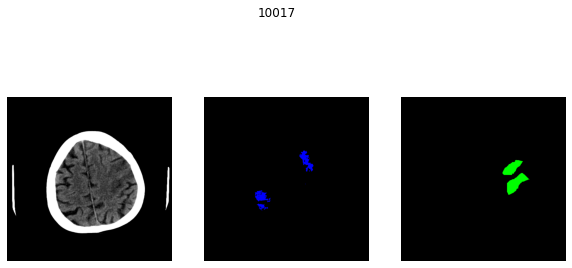

In [14]:
i = 7
plot(images[i], predictions[i], ids[i])